# 3 Pre-processing Work and Model

## 3.1 Table of Contents

<a id='Imports'></a>
## 3.2 Import Relevant Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import itertools
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
from math import sqrt
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings(action='ignore')

<a id="Load-Data"></a>
## 3.3 Load the Data

Our goal is to model solar power generation effectively. Therefore, we should consider filtering out nighttime data, specifically during hours when AC_POWER and irradiation is zero, to focus solely on the time periods when solar power generation is feasible.

In [2]:
# Load the filtered data from CSV file into a Pandas DataFrame named 'filter_df'
filtered_df = pd.read_csv('/Users/aysebusra/Desktop/Springboard/Capstone_3/filtered_data.csv')

<a id="Explore-the-Data"></a>
## 3.4 Explore the Data

In [3]:
# Display the dimensions of the filtered_df data
filtered_df.shape

(32022, 17)

The filtered data has 32,022 rows and 16 columns

In [4]:
# Display the first few rows of the filtered_df data
filtered_df.head()

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
0,2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
1,2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2,2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
3,2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
4,2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


The filtered data has the following columns:'DATE_TIME', 'INVERTER', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATE', 'TIME', 'DAY', 'MONTH', 'WEEK', 'HOURS','MINUTES' and 'EFFICIENCY.

In [5]:
# Get an overview of the structure and characteristics of the filtered_df data
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32022 entries, 0 to 32021
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            32022 non-null  object 
 1   INVERTER             32022 non-null  int64  
 2   DC_POWER             32022 non-null  float64
 3   AC_POWER             32022 non-null  float64
 4   DAILY_YIELD          32022 non-null  float64
 5   TOTAL_YIELD          32022 non-null  float64
 6   AMBIENT_TEMPERATURE  32022 non-null  float64
 7   MODULE_TEMPERATURE   32022 non-null  float64
 8   IRRADIATION          32022 non-null  float64
 9   DATE                 32022 non-null  object 
 10  TIME                 32022 non-null  object 
 11  DAY                  32022 non-null  int64  
 12  MONTH                32022 non-null  int64  
 13  WEEK                 32022 non-null  int64  
 14  HOURS                32022 non-null  int64  
 15  MINUTES              32022 non-null 

There are no missing values in the dataset. Most of the data are numeric except for the ' DATE_TIME', ' DATE' and 'TIME' columns. Converting the ' DATE_TIME' column to datetime format will enable us to perform time-based analysis.

In [6]:
# Check for duplicate rows in the filtered_df data
duplicates = filtered_df.duplicated().sum()
print(f"Number of duplicate rows in filtered data: {duplicates}")

Number of duplicate rows in filtered data: 0


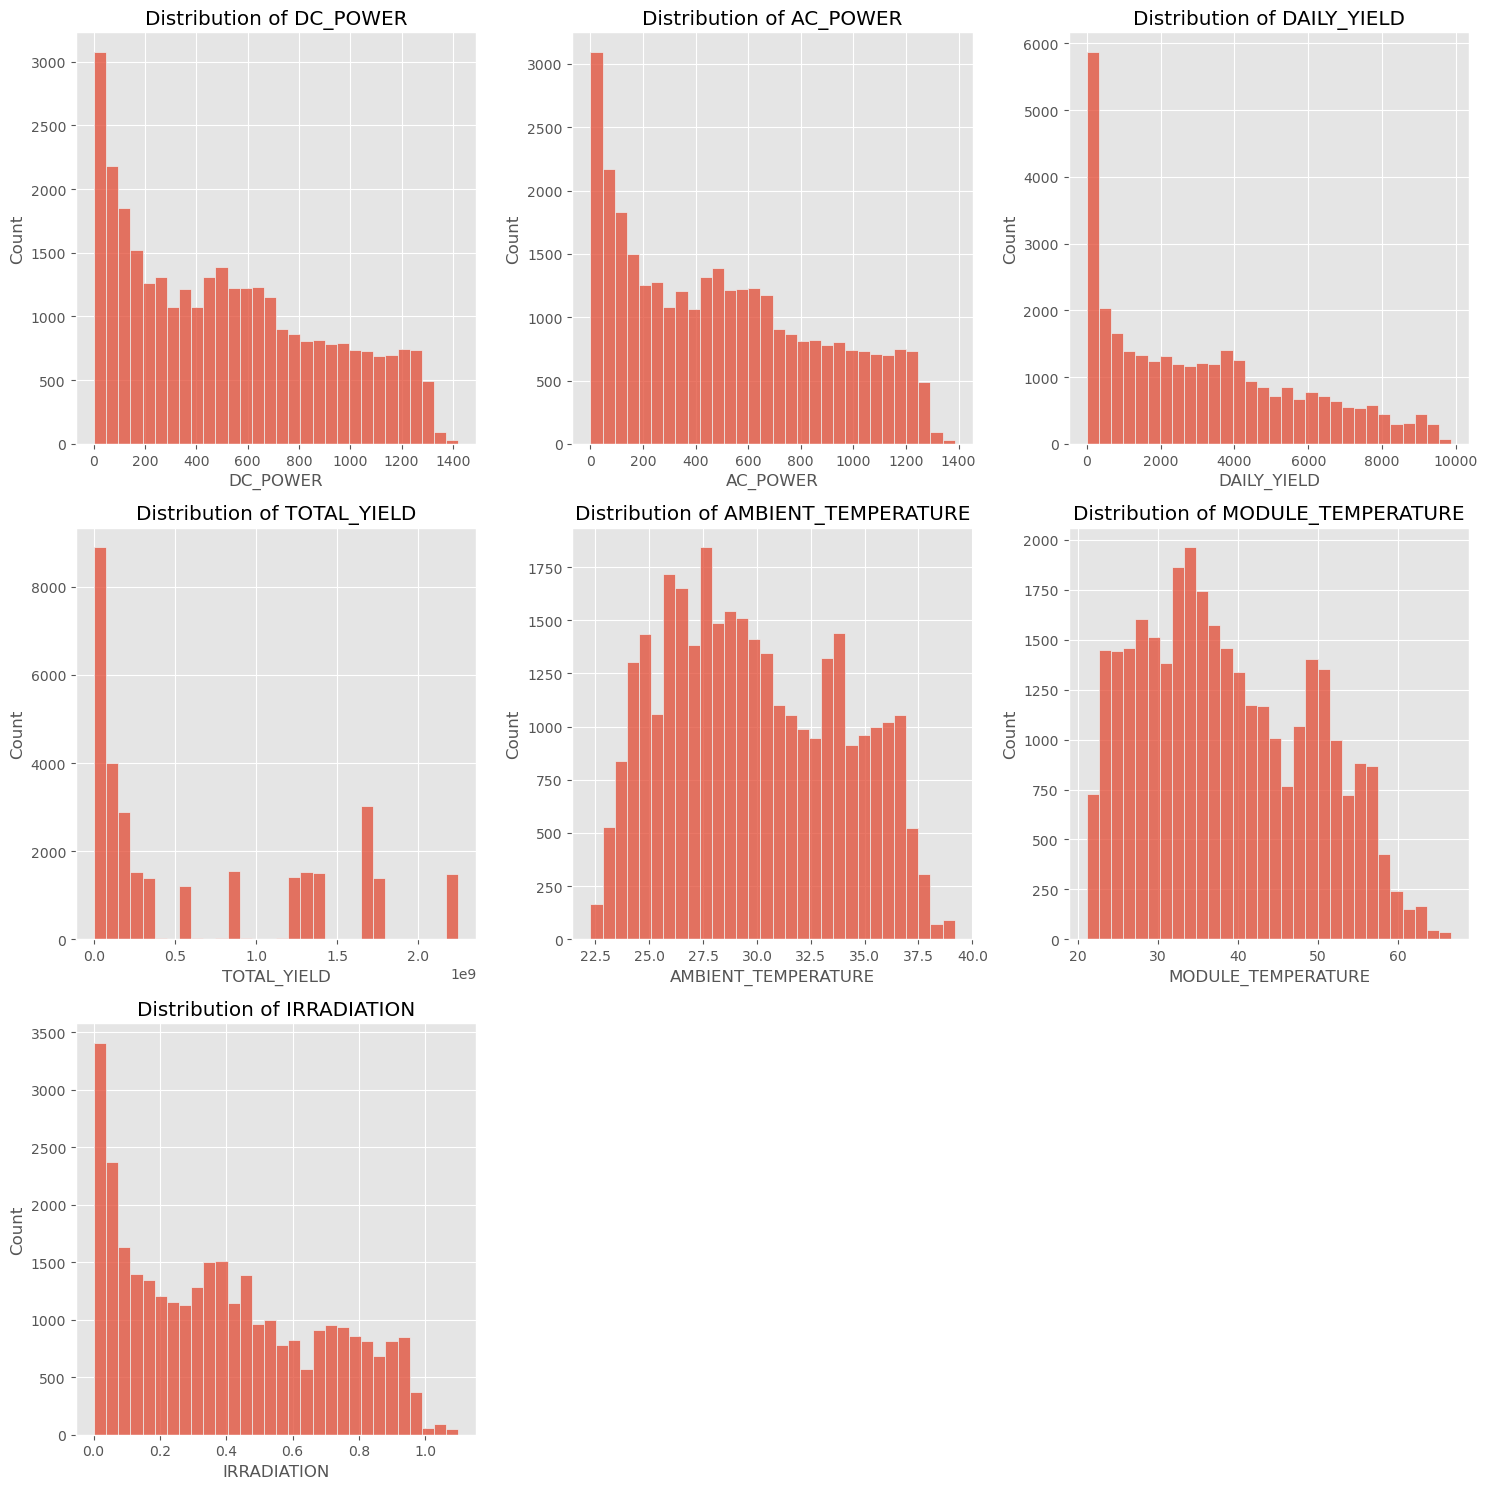

In [7]:
# List of numerical columns
selected_columns = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 
                              'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


# Plot histograms
plt.figure(figsize=(15, 15))
for i, col in enumerate(selected_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(filtered_df[col], bins=30, alpha=0.75)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Based on the histogram plot: 
* DC_POWER and AC_POWER are right-skewed.
* DAILY_YIELD is right-skewed, showing a more continuous range of values.
* The TOTAL_YIELD is right-skewed with noticeable peaks.
* AMBIENT_TEMPERATURE is approximately normal distribution centered around 27.5°C.
* MODULE_TEMPERATURE is right-skewed with most values between 20°C and 40°C.
* IRRADIATION is right-skewed, with most values between 0 and 1.

<a id='Preprocessing'></a>
## 3.5 Preprocessing Data

<a id="Convert-Datetime-Indexing"></a>
### 3.5.1 Datetime Conversion and Indexing

In [8]:
# Convert 'DATE_TIME' columns to Datetime in the filtered_df data
filtered_df['DATE_TIME'] = pd.to_datetime(filtered_df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Set DATE_TIME as index
filtered_df.set_index(['DATE_TIME'], inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


<a id="Cyclical-Transformation"></a>
### 3.5.2 Cyclical Feature Transformation

Since both 'HOURS' and 'MINUTES' are cyclical,these features converted into sine and cosine components. This transformation helps the model to recognize the continuity at the end and start of each cycle.

In [9]:
# Transform the HOURS and MINUTES into cyclical features
filtered_df['HOURS_SIN'] = np.sin(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['HOURS_COS'] = np.cos(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['MINUTES_SIN'] = np.sin(filtered_df['MINUTES'] * (2. * np.pi / 60))
filtered_df['MINUTES_COS'] = np.cos(filtered_df['MINUTES'] * (2. * np.pi / 60))

<a id="Dropping"></a>
### 3.5.3 Dropping Redundant Columns

In [10]:
# Drop the 'DATE', 'TIME', 'HOURS', and 'MINUTES'column in the filtered_df data
filtered_df.drop(['DATE', 'TIME', 'HOURS', 'MINUTES'], axis=1, inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,HOURS_SIN,HOURS_COS,MINUTES_SIN,MINUTES_COS
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.0


<a id="Duplicates"></a>
### 3.5.4 Check for Duplicate Timestamps

In [11]:
# Check for duplicate indices
filtered_df[filtered_df.index.duplicated(keep=False)] 

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,HOURS_SIN,HOURS_COS,MINUTES_SIN,MINUTES_COS
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.077230,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.077230,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.077230,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.077230,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.077230,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 18:45:00,18,3.771429,3.635714,4156.857143,5.207579e+05,23.965923,23.283976,0.002635,17,6,25,96.401515,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,19,2.857143,2.757143,3930.714286,1.211314e+08,23.965923,23.283976,0.002635,17,6,25,96.500000,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,20,3.780000,3.633333,4321.800000,2.427691e+06,23.965923,23.283976,0.002635,17,6,25,96.119929,-1.0,-1.836970e-16,-1.0,-1.836970e-16


The duplicates in the dataset are likely due to simultaneous recordings from multiple inverters. Aggregating this data is beneficial, as it allows for a consistent analysis of inverter efficiency and helps identify overarching trends.

<a id="Aggregation"></a>
### 3.5.5 Aggregate the Data

In [12]:
# Aggregate the selected columns by taking the mean of each timestamp
selected_columns = ['AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 
                    'HOURS_SIN', 'HOURS_COS', 'MINUTES_SIN', 'MINUTES_COS']
aggregated_df = filtered_df.groupby('DATE_TIME')[selected_columns].mean()

<a id="Resampling-Handling-Missing-Values"></a>
### 3.5.6 Resampling and Handling Missing Values

In [13]:
# Resample the aggregated data to regular 15-minute intervals
resampled_df = aggregated_df.resample('15T').asfreq()

# Check for missing values after resampling
resampled_df.isnull().sum()

AC_POWER               1499
AMBIENT_TEMPERATURE    1499
MODULE_TEMPERATURE     1499
IRRADIATION            1499
HOURS_SIN              1499
HOURS_COS              1499
MINUTES_SIN            1499
MINUTES_COS            1499
dtype: int64

There are 1,499 missing values across all features after resampling, which suggests that no data was recorded during these 15-minute intervals.

In [14]:
# Interpolate missing timestamps
resampled_df.interpolate(method='linear', inplace=True)

In [15]:
# Check again for missing values
resampled_df.isnull().sum()

AC_POWER               0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
HOURS_SIN              0
HOURS_COS              0
MINUTES_SIN            0
MINUTES_COS            0
dtype: int64

Confirmed that the resampled dataframe has no missing values across all of its columns after the interpolation operation.

<a id="Decomposition-Sttistical-Tests"></a>
## 3.6 Decomposition and Statistical Testing

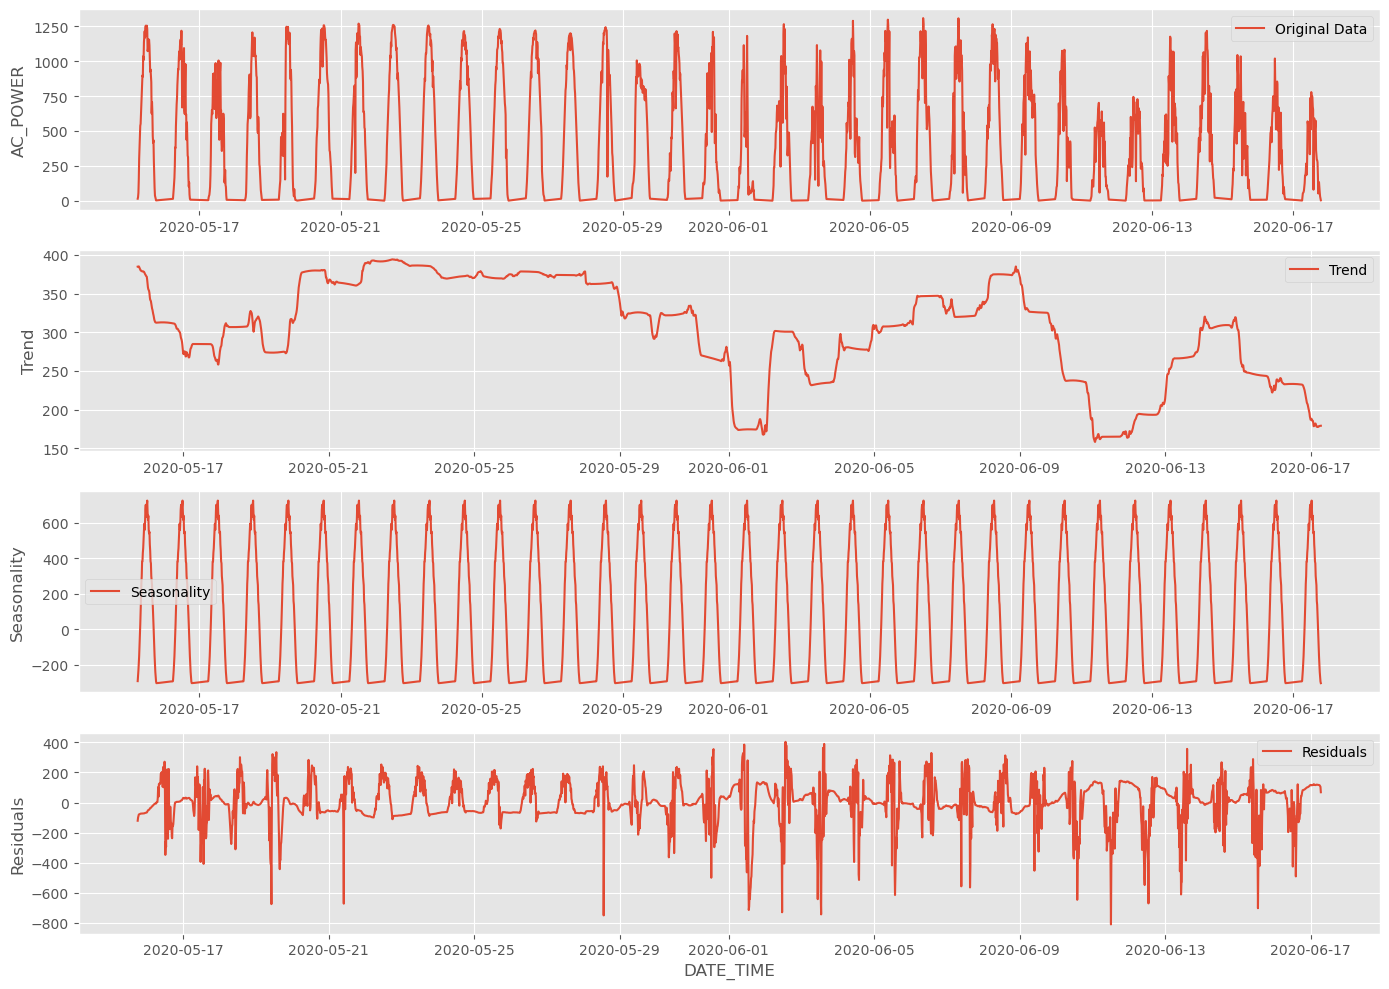

In [16]:
# Make a variable called decomposition, and assign it target variable and period passed to seasonal_decompose() 
decomposition = seasonal_decompose(resampled_df['AC_POWER'], period=96)

# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(14,10))
plt.subplot(4,1,1)
plt.plot(resampled_df['AC_POWER'], label='Original Data')
plt.ylabel('AC_POWER')
plt.legend(loc = 'best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.ylabel('Trend')
plt.legend(loc = 'best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.ylabel('Seasonality')
plt.legend(loc = 'best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc = 'best')
plt.ylabel('Residuals')
plt.xlabel('DATE_TIME')

plt.tight_layout()
plt.show()

* The original data shows fluctuations in AC_POWER generation, with clear peaks during daylight hours due to sunlight and drops to nearly zero at night.
* There is a noticeable decreasing trend in AC power output from May 15 to June 17, 2020, which may be attributed to seasonal changes or other external factors that impact efficiency.
* The seasonal plot displays a consistent pattern that matches the daily solar cycle, with peaks in midday solar generation and troughs at night when there is no solar activity.
* The residuals plot shows random fluctuations, suggesting that there are additional factors influencing power generation that are not captured by seasonal or trend components. These fluctuations could be due to weather conditions or operational issues.

<a id="ADF"></a>
### 3.6.1 ADF Test

In [17]:
# Applying the Augmented Dickey-Fuller (ADF) test on the 'AC_POWER' data
adf_test = adfuller(resampled_df['AC_POWER'])

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -14.046848502474456
p-value: 3.2293424716514176e-26
Critical Values: {'1%': -3.4323926176073427, '5%': -2.8624425047982394, '10%': -2.567250423444633}


* The ADF statistic is much lower than the critical values at common significance levels (1%, 5%, and 10%). This suggests a strong rejection of the null hypothesis. 
* The p-value is extremely small, which strongly indicates that reject the null hypothesis.
* The test results indicates that the time series is stationary. This means it can be modeled as is, without needing further differencing to stabilize the mean.

<a id="KPSS"></a>
### 3.6.2 KPSS Test

In [18]:
# Applying the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the 'AC_POWER' data
kpss_test = kpss(resampled_df['AC_POWER'])
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('Critical Values:', kpss_test[3])

KPSS Statistic: 0.19517009520822529
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* The KPSS statistic is below the critical values, and the p-value is above 0.05, which suggests that we fail to reject the null hypothesis of stationarity.
* Both tests confirm that time series data is stationary, so there is no need for differencing to achieve stationarity. 

<a id="ACF-PACF"></a>
### 3.6.3 Plot ACF and PACF

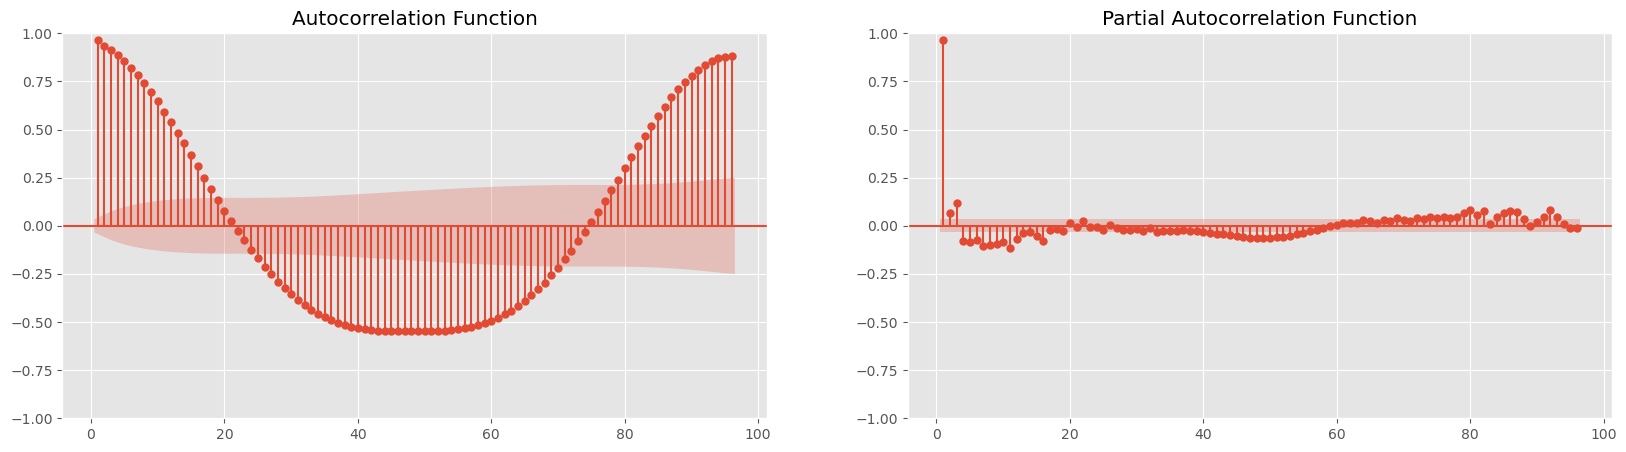

In [19]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot the Autocorrelation Function (ACF)
plot_acf(resampled_df['AC_POWER'], zero=False, ax=ax1, lags=96, alpha=0.05)
ax1.set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(resampled_df['AC_POWER'], zero=False, ax=ax2, lags=96, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function')

plt.show()

* The ACF plot shows a wave-like pattern that gradually diminishes, suggesting seasonality in the data.
* The PACF plot has a significant spike at lag 1 and then quickly drops off, indicating a potential AR(1) component.
* Based on the plots:
    * AR (p): The significant spike at lag 1 in the PACF suggests an AR(1) component, so p=1.
    * Differencing (d): Since the series is already stationary, d=0.
    * MA (q): The ACF plot does not show a clear cutoff, suggesting q=0 or q=1.

<a id="Modeling"></a>
## 3.7 Modeling

<a id="SARIMA"></a>
### 3.7.1 SARIMA Model

Since the data has clear seasonal patterns, as indicated by decomposition and the periodic spikes in the ACF and PACF, it would be more efficient to start directly with SARIMA. 

<a id="Data-Preparation"></a>
#### 3.7.1.1 Data Preparation

In [20]:
# Split the data into training and testing sets based on the target variable
split = int(len(resampled_df) * 0.8)
train, test = resampled_df[:split], resampled_df[split:]

# Extract 'AC_POWER' for training and testing
train_ac_power = train['AC_POWER']
test_ac_power = test['AC_POWER']

In [21]:
print(train_ac_power.shape)
print(test_ac_power.shape)

(2576,)
(644,)


<a id="Sarima"></a>
#### 3.7.1.2 Making a SARIMA Model

In [22]:
# Define SARIMA model
sarima_model = SARIMAX(train_ac_power, order=(1, 0, 0), seasonal_order=(1, 1, 0, 96))
sarima_model_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92288D+00    |proj g|=  6.57964D-02


 This problem is unconstrained.



At iterate    5    f=  5.91765D+00    |proj g|=  1.84775D-03

At iterate   10    f=  5.91247D+00    |proj g|=  2.74167D-02

At iterate   15    f=  5.90046D+00    |proj g|=  2.28239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   4.364D-06   5.900D+00
  F =   5.9004538036754539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [23]:
# Predict using SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=len(test_ac_power))
sarima_forecast = pd.Series(sarima_forecast, index=test_ac_power.index)

In [24]:
# Evaluate the SARIMA model
rmse = np.sqrt(mean_squared_error(test['AC_POWER'], sarima_forecast))
mape = np.mean(np.abs((test['AC_POWER'] - sarima_forecast) / test['AC_POWER'])) * 100

print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAPE: {mape}")

SARIMA RMSE: 187.43981769027738
SARIMA MAPE: 91.07737346631659


* The average squared error of the predictions is 187.44. It means that the model's predictions deviate from the actual values by approximately 187.44 units of AC_POWER on average. 
* A MAPE of 91.08% indicates that, on average, the forecasted values deviate from the actual values by 91.08%. This is relatively high, suggesting that the model may have difficulty capturing some patterns or variations in the data accurately.

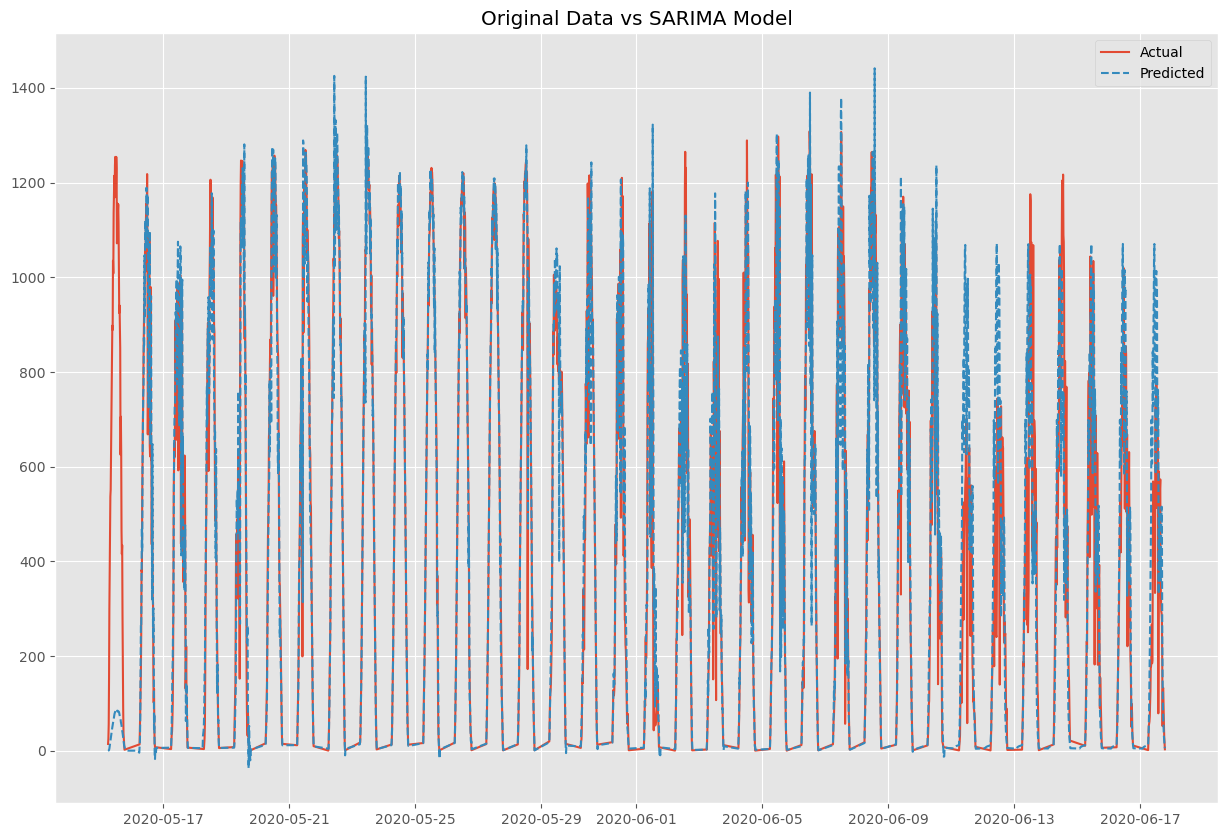

In [25]:
# Plot predicted vs actual values for SARIMA
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model_fit.predict(start=0, end=len(resampled_df)-1), linestyle='dashed', label='Predicted')
plt.title('Original Data vs SARIMA Model')
plt.legend()
plt.show()

* The model seems to capture the overall seasonal and daily patterns in the data quite well, with predicted values closely following the peaks and troughs of the actual values. However, there are noticeable deviations, particularly in the magnitude of the peaks, where the predicted values sometimes fall short or overshoot.

<a id="Tune-SARIMA"></a>
#### 3.7.1.3 Fine-Tuning a SARIMA Model

In [37]:
# Define the range for p, d, q parameters
#p = d = q = range(0, 2)
#pdq = list(itertools.product(p, d, q))

# Define the range for seasonal parameters with a seasonal period of 96
#seasonal_pdq = [(x[0], x[1], x[2], 96) for x in pdq]

#best_aic = float("inf")
#best_params = None

# Iterate over all combinations of p, d, q and seasonal parameters
#for param in pdq:
#   for seasonal_param in seasonal_pdq:
#       try:
            # Define the SARIMAX model
#           mod = SARIMAX(train_ac_power,
#                           order=param,
#                           seasonal_order=seasonal_param,
#                           enforce_stationarity=False,
#                           enforce_invertibility=False)
            
            # Fit the model
#           results = mod.fit(disp=False)
            
            # Check if the current model has a lower AIC
#           if results.aic < best_aic:
#               best_aic = results.aic
#               best_params = (param, seasonal_param)
            
            # Print the model and its AIC
#           print('ARIMA{}x{}96 - AIC:{}'.format(param, seasonal_param, results.aic))
#       except:
#           continue

#print('Best model: ARIMA{}x{}96 - AIC:{}'.format(best_params[0], best_params[1], best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 96)96 - AIC:39607.3917373652
ARIMA(0, 0, 0)x(0, 0, 1, 96)96 - AIC:36014.50351298533
ARIMA(0, 0, 0)x(0, 1, 0, 96)96 - AIC:32544.453297698296
ARIMA(0, 0, 0)x(0, 1, 1, 96)96 - AIC:30492.369325401814
ARIMA(0, 0, 0)x(1, 0, 0, 96)96 - AIC:32453.526479703603
ARIMA(0, 0, 0)x(1, 0, 1, 96)96 - AIC:31678.340509404792
ARIMA(0, 0, 0)x(1, 1, 0, 96)96 - AIC:30919.30821502376
ARIMA(0, 0, 0)x(1, 1, 1, 96)96 - AIC:30463.6047691462
ARIMA(0, 0, 1)x(0, 0, 0, 96)96 - AIC:36646.668259826416
ARIMA(0, 0, 1)x(0, 0, 1, 96)96 - AIC:33745.1803949602
ARIMA(0, 0, 1)x(0, 1, 0, 96)96 - AIC:31403.14012622135
ARIMA(0, 0, 1)x(0, 1, 1, 96)96 - AIC:29136.456559488222
ARIMA(0, 0, 1)x(1, 0, 0, 96)96 - AIC:31289.836495133786
ARIMA(0, 0, 1)x(1, 0, 1, 96)96 - AIC:30288.864717592543
ARIMA(0, 0, 1)x(1, 1, 0, 96)96 - AIC:29697.787551925067
ARIMA(0, 0, 1)x(1, 1, 1, 96)96 - AIC:29136.796749916524
ARIMA(0, 1, 0)x(0, 0, 0, 96)96 - AIC:31127.805892948432
ARIMA(0, 1, 0)x(0, 0, 1, 96)96 - AIC:30018.601799502758
A

In [ ]:
# Define the range for p, d, q parameters
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define the range for seasonal parameters with a seasonal period of 96
seasonal_pdq = [(x[0], x[1], x[2], 96) for x in pdq]

best_aic = float("inf")
best_params = None

# Iterate over all combinations of p, d, q and seasonal parameters
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Define the SARIMAX model
            mod = SARIMAX(train_ac_power,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            # Fit the model
            results = mod.fit(disp=False)
            
            # Check if the current model has a lower AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
            
            # Print the model and its AIC
            print('ARIMA{}x{}96 - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue

print('Best model: ARIMA{}x{}96 - AIC:{}'.format(best_params[0], best_params[1], best_aic))


ARIMA(0, 0, 0)x(0, 0, 0, 96)96 - AIC:39607.3917373652
ARIMA(0, 0, 0)x(0, 0, 1, 96)96 - AIC:36014.50351298533
ARIMA(0, 0, 0)x(0, 0, 2, 96)96 - AIC:33509.069418768486
ARIMA(0, 0, 0)x(0, 1, 0, 96)96 - AIC:32544.453297698296
ARIMA(0, 0, 0)x(0, 1, 1, 96)96 - AIC:30492.369325401814


<a id="Fit-Forecast"></a>
#### 3.7.1.4 Fitting and Forecasting with Optimal SARIMA Parameters

In [35]:
# Define SARIMA model
sarima_model = SARIMAX(train_ac_power, order=(1, 1, 1), seasonal_order=(1, 1, 1, 96))
sarima_model_fit = sarima_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89608D+00    |proj g|=  7.18027D-02

At iterate    5    f=  5.86123D+00    |proj g|=  7.82523D-03

At iterate   10    f=  5.85146D+00    |proj g|=  1.74339D-02

At iterate   15    f=  5.76530D+00    |proj g|=  1.40597D-02

At iterate   20    f=  5.76436D+00    |proj g|=  2.18566D-02
  ys=-1.321E-04  -gs= 2.983E-04 BFGS update SKIPPED

At iterate   25    f=  5.76375D+00    |proj g|=  4.96285D-05

At iterate   30    f=  5.76374D+00    |proj g|=  8.69074D-04
  ys=-1.966E-05  -gs= 1.433E-04 BFGS update SKIPPED

At iterate   35    f=  5.76035D+00    |proj g|=  9.55486D-03

At iterate   40    f=  5.75977D+00    |proj g|=  1.30280D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  =

In [36]:
# Forecast using SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=len(test_ac_power))
sarima_forecast = pd.Series(sarima_forecast, index=test_ac_power.index)

In [37]:
# Calculate metrics for SARIMA
rmse = np.sqrt(mean_squared_error(test['AC_POWER'], sarima_forecast))
mape = np.mean(np.abs((test['AC_POWER'] - sarima_forecast) / test['AC_POWER'])) * 100

print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAPE: {mape}")

SARIMA RMSE: 177.41979009789623
SARIMA MAPE: 663.4658438718394


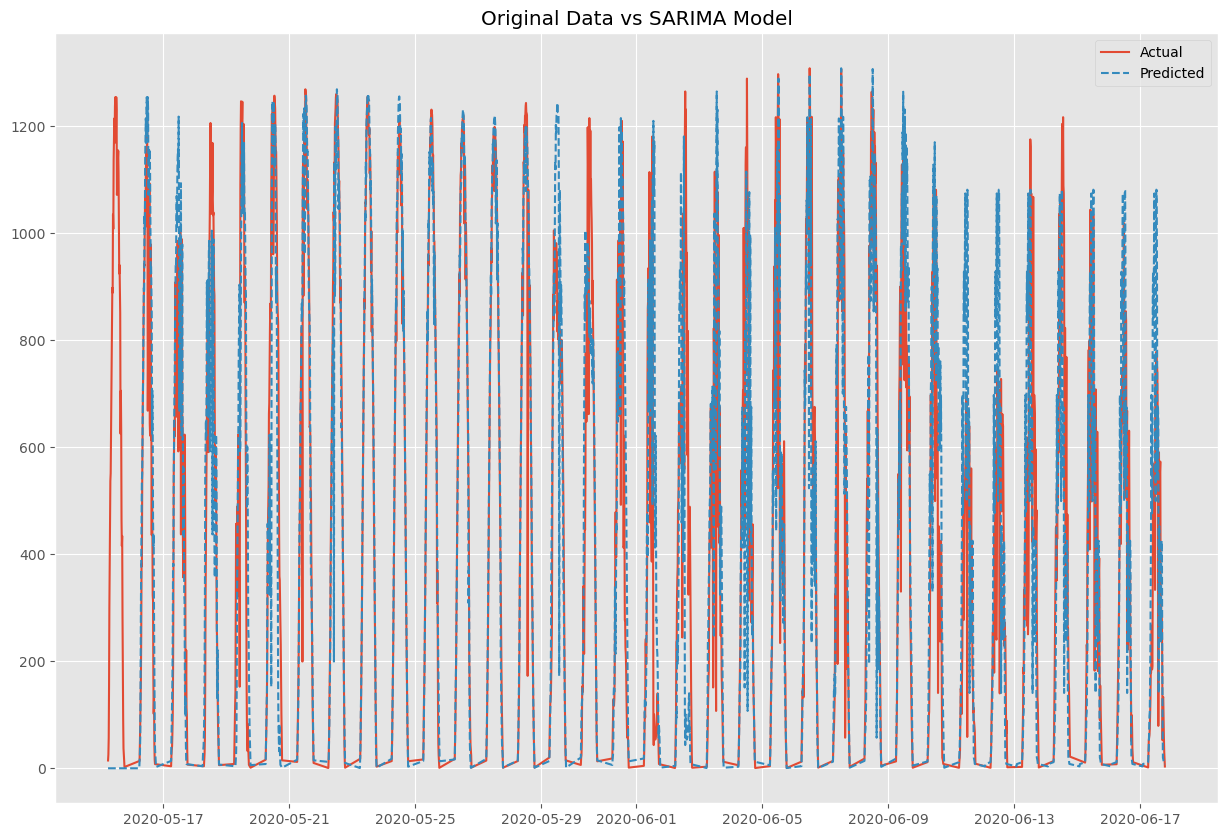

In [34]:
# Plot forecast against actual values
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model_fit.predict(start=0, end=len(resampled_df)-1), linestyle='dashed', label='Predicted')
plt.title('Original Data vs SARIMA Model')
plt.legend()
plt.show()

<a id="Machine Learning"></a>
### 3.7.2 Machine Learning Models

<a id="Splitting"></a>
#### 3.7.2.1 Split Data

In [26]:
#Define features and target
selected_columns = ['AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 
                    'hours_sin', 'hours_cos', 'minutes_sin', 'minutes_cos']
data = resampled_df[selected_columns]

In [27]:
# Split the data into features and target variable
X = data.drop('AC_POWER', axis=1)
y = data['AC_POWER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Display the shapes of the resulting datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2576, 7)
(644, 7)
(2576,)
(644,)


In [28]:
# Convert arrays to dataframes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['AC_POWER'])
y_test_df = pd.DataFrame(y_test, columns=['AC_POWER'])

# Display the first few rows of the training and testing dataframes
print("X_train:")
print(X_train_df.head())

print("\nX_test:")
print(X_test_df.head())

print("\ny_train:")
print(y_train_df.head())

print("\ny_test:")
print(y_test_df.head())

X_train:
                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-15 06:00:00            24.742787           24.077230     0.012962   
2020-05-15 06:15:00            24.763911           24.356189     0.021038   
2020-05-15 06:30:00            24.786323           24.548886     0.042435   
2020-05-15 06:45:00            25.048245           25.746662     0.103496   
2020-05-15 07:00:00            25.673202           28.674707     0.199450   

                     hours_sin     hours_cos   minutes_sin   minutes_cos  
DATE_TIME                                                                 
2020-05-15 06:00:00   1.000000  6.123234e-17  0.000000e+00  1.000000e+00  
2020-05-15 06:15:00   1.000000  6.123234e-17  1.000000e+00  6.123234e-17  
2020-05-15 06:30:00   1.000000  6.123234e-17  1.224647e-16 -1.000000e+00  
2020-05-15 06:45:00   1.000000  6.123234e-17 -1.000000e+00 -1.836970e-16  
2

<a id="Transform-Scale"></a>
#### 3.7.2.2 Power Transformation and Scaling

In [98]:
# Apply PowerTransformer to the features
pt = PowerTransformer()
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

In [43]:
# Apply MinMaxScaler to the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Convert the transformed numpy arrays back to DataFrames for better visualization
X_train_final = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_final = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Transformed and Scaled Training Data:")
print(X_train_final.head())

print("\nTransformed and Scaled Testing Data:")
print(X_test_final.head())

Transformed and Scaled Training Data:
                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
DATE_TIME                                                                   
2020-05-15 06:00:00             0.146388            0.199856     0.040313   
2020-05-15 06:15:00             0.147637            0.215918     0.067306   
2020-05-15 06:30:00             0.148962            0.226773     0.134606   
2020-05-15 06:45:00             0.164447            0.290150     0.297604   
2020-05-15 07:00:00             0.201394            0.420145     0.487965   

                     hours_sin  hours_cos  minutes_sin  minutes_cos  
DATE_TIME                                                            
2020-05-15 06:00:00   1.000000   0.794395          0.5          1.0  
2020-05-15 06:15:00   1.000000   0.794395          1.0          0.5  
2020-05-15 06:30:00   1.000000   0.794395          0.5          0.0  
2020-05-15 06:45:00   1.000000   0.794395          0.0          0.5  
20

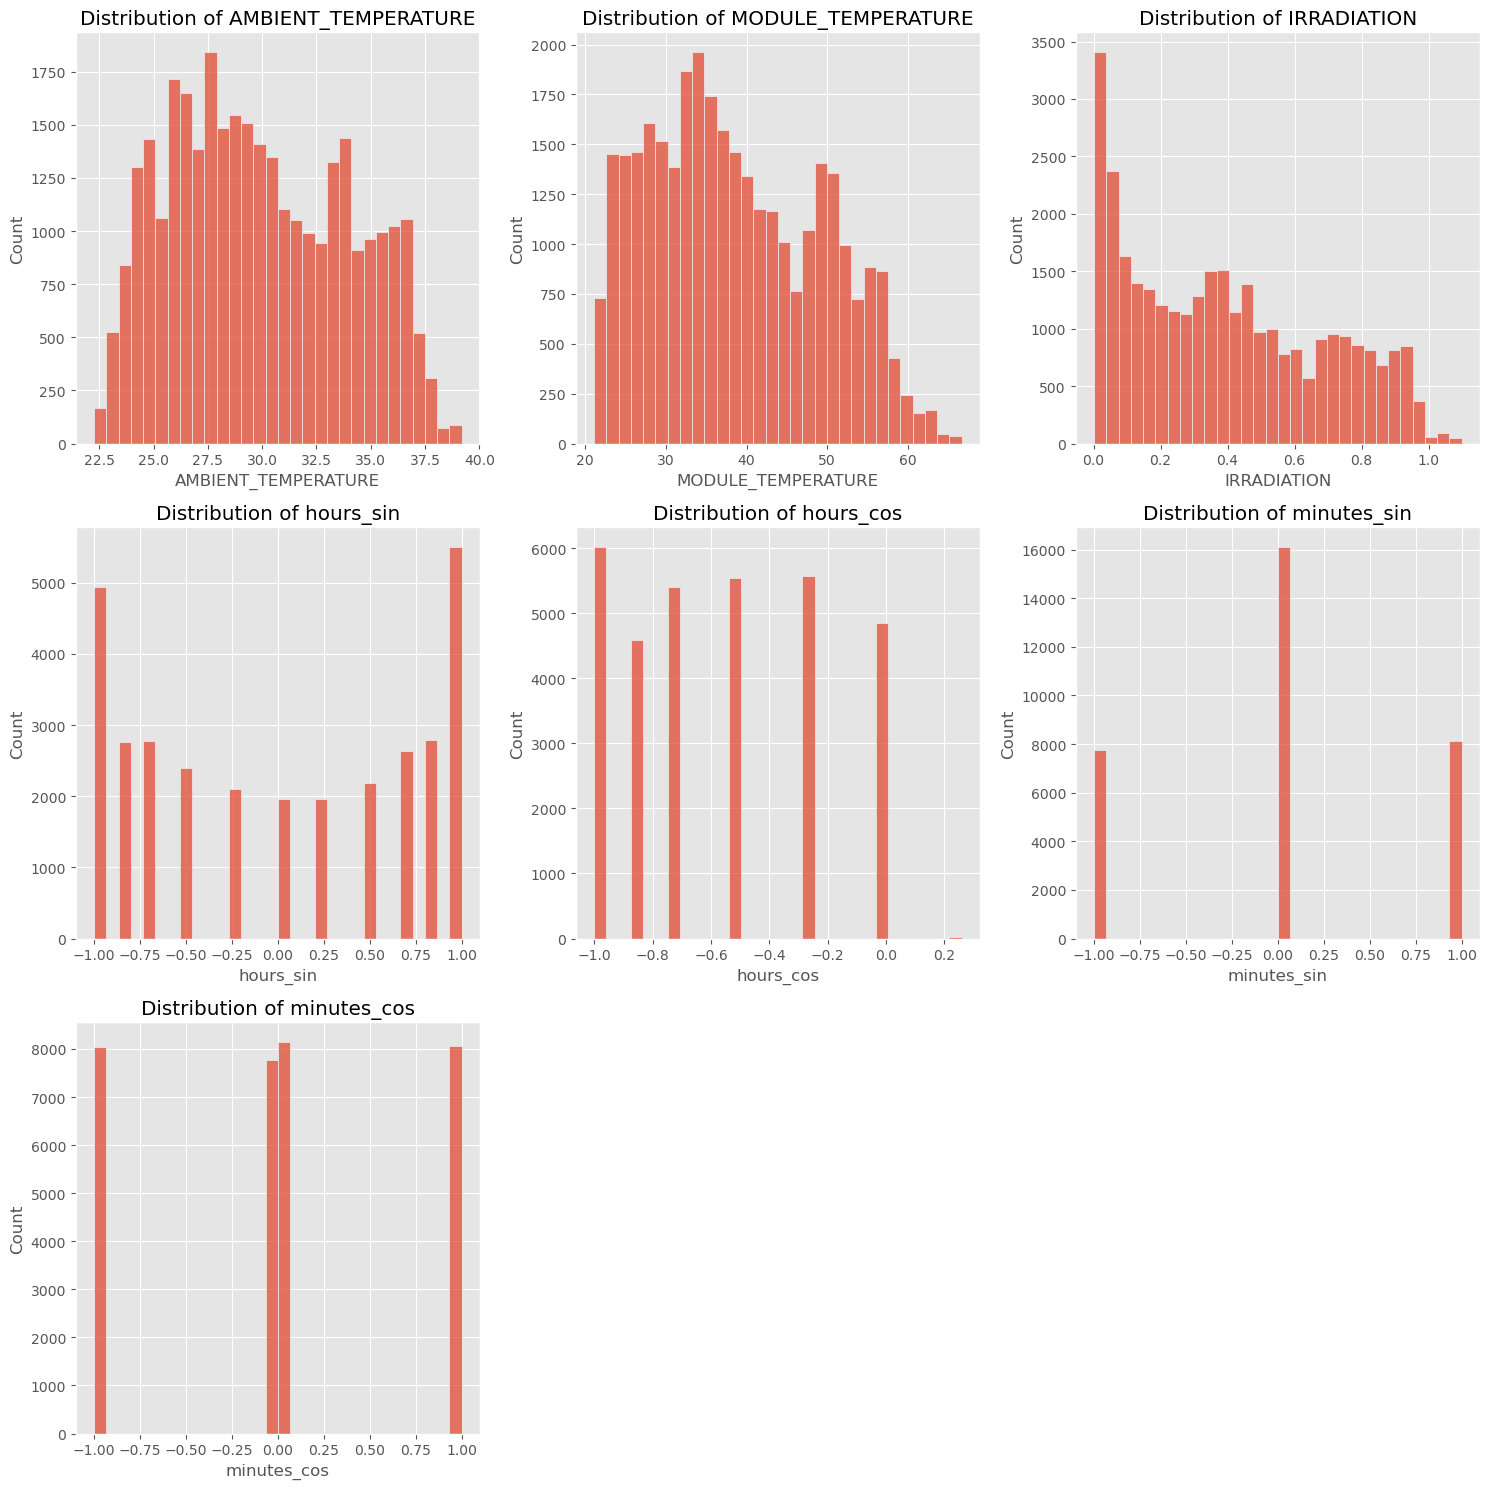

In [45]:
# List of numerical columns
numerical_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 
                    'hours_sin', 'hours_cos', 'minutes_sin', 'minutes_cos']


# Plot histograms for numerical columns
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(filtered_df[col], bins=30, alpha=0.75)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

<a id="Random-Forest"></a>
#### 3.7.2.3 Random Forest

In [69]:
# Initialize models
rf_model = RandomForestRegressor()

# Train the models
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"Rondom Forest RMSE: {rmse}")
print(f"Rondom Forest MAPE: {mape}")

Rondom Forest RMSE: 72.50103552433728
Rondom Forest MAPE: 14.919219162219836


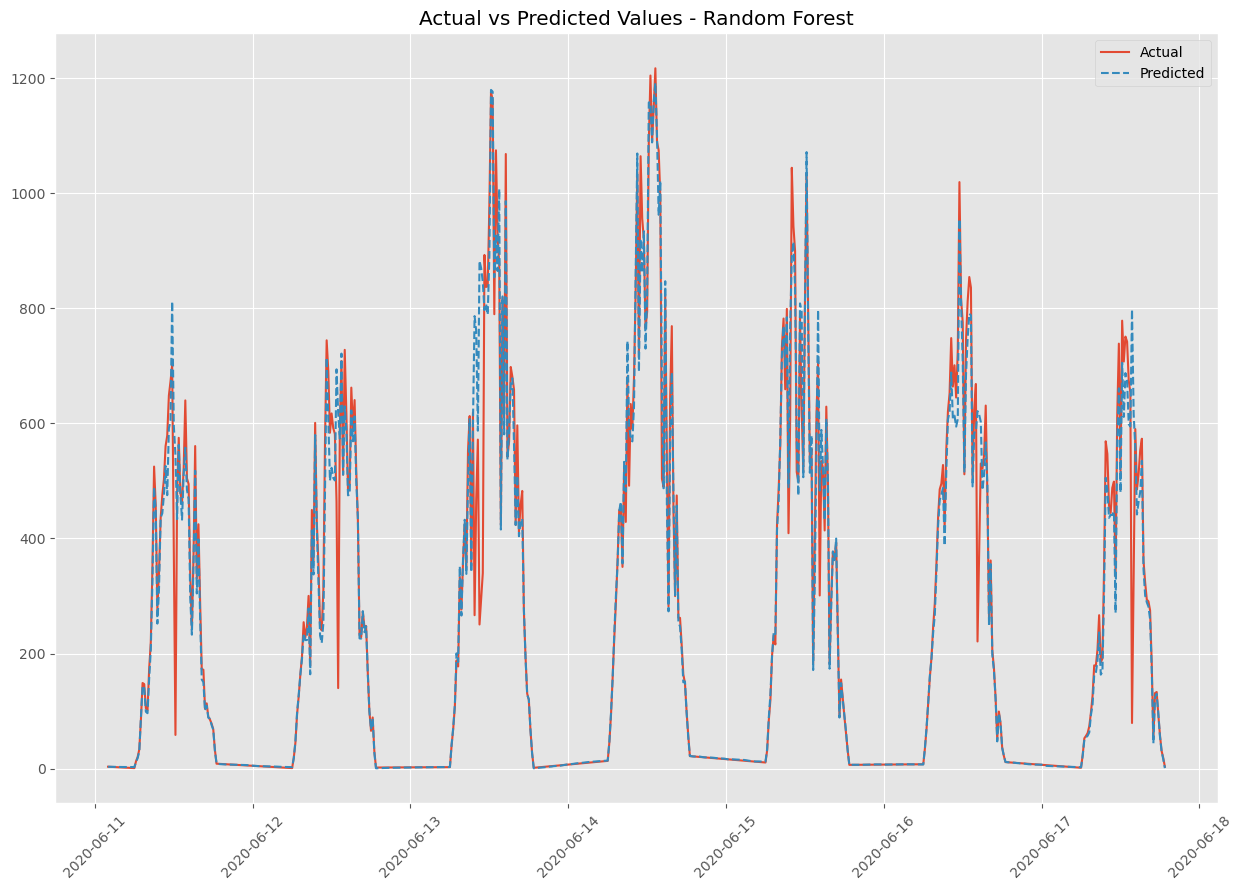

In [53]:
# Plot Random Forest predictions
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - Random Forest')
plt.legend()
plt.xticks(rotation=45)
plt.show()

<a id="Random-Forest-Tuning"></a>
##### 3.7.2.3.1 Making a k-fold cross-validation with hyperparameter tuning for the Random Forest

In [65]:
# Define the range of number of splits
num_splits_range = [3, 5, 7, 10]

# Dictionary to store cross-validation scores for each number of splits
cv_scores_rf_test = {}
cv_scores_rf_train = {}

for num_splits in num_splits_range:
    # Define cross-validation strategy with the current number of splits
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # Define the Random Forest Regression model
    rf_model = RandomForestRegressor()
    
    # Perform hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train.values.ravel())
    
    # Print best estimator and best score
    print(f"{num_splits}-fold Cross-Validation Best Estimator:")
    print(grid_search.best_estimator_)
    print(f"{num_splits}-fold Cross-Validation Best Score (RMSE):")
    print(-grid_search.best_score_)  # Negate the score to get the actual RMSE
    
    # Get the best model
    best_rf_model = grid_search.best_estimator_
    
    # Evaluate the best model using cross-validation on the training set
    cv_scores_rf_train[num_splits] = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Evaluate the best model using cross-validation on the testing set
    cv_scores_rf_test[num_splits] = cross_val_score(best_rf_model, X_test_scaled, y_test, cv=kf, scoring='neg_root_mean_squared_error')

# Print the cross-validation scores for each number of splits
for num_splits in num_splits_range:
    print(f"{num_splits}-fold Cross-Validation Scores (RMSE):")
    
    # Mean cross-validation score on the training set
    mean_cv_score_train = -np.mean(cv_scores_rf_train[num_splits])
    print("Mean cross-validation RMSE score on training set:", mean_cv_score_train)
    
    # Mean cross-validation score on the testing set
    mean_cv_score_test = -np.mean(cv_scores_rf_test[num_splits])
    print("Mean cross-validation RMSE score on testing set:", mean_cv_score_test)
    
    # Standard deviation in cross-validation scores on the testing set
    std_cv_score_test = np.std(cv_scores_rf_test[num_splits])
    print("Standard deviation in cross-validation RMSE scores on testing set:", std_cv_score_test)


3-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)
3-fold Cross-Validation Best Score (RMSE):
69.44859257117857
5-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=4,
                      n_estimators=300)
5-fold Cross-Validation Best Score (RMSE):
69.27547500831417
7-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200)
7-fold Cross-Validation Best Score (RMSE):
67.91623004461171
10-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_features='log2', min_samples_leaf=2, n_estimators=300)
10-fold Cross-Validation Best Score (RMSE):
66.0936445162775
3-fold Cross-Validation Scores (RMSE):
Mean cross-validation RMSE score on training set: 70.39881886527404
Mean cross-validation RMSE score on testing set: 73.4

In [66]:
# Create a dictionary to hold the data
data = {
    "Cross-Validation": ["3-fold", "5-fold", "7-fold", "10-fold"],
    "Max Depth": [20, 20, 20, None],
    "Max Features": ["sqrt", "log2", "sqrt", "log2"],
    "N_Estimators": [None, 300, 200, 300],
    "RMSE Score": [69.45, 69.28, 67.92, 66.09],
    "Mean CV RMSE Score (Testing Set)": [73.44, 76.26, 71.21, 68.63],
    "Standard Deviation": [5.09, 11.49, 17.93, 24.17]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the title
title = "Random Forest Model Cross-Validation Results"

# Display the title and DataFrame
print(title)
df

Random Forest Model Cross-Validation Results


,Cross-Validation,Max Depth,Max Features,N_Estimators,RMSE Score,Mean CV RMSE Score (Testing Set),Standard Deviation
0,3-fold,20.0,sqrt,NaN,69.45,73.44,5.09
1,5-fold,20.0,log2,300.0,69.28,76.26,11.49
2,7-fold,20.0,sqrt,200.0,67.92,71.21,17.93
3,10-fold,NaN,log2,300.0,66.09,68.63,24.17


<a id="XGBoost"></a>
#### 3.7.2.4 XGBoost

In [54]:
# Initialize models
xgb_model = xgb.XGBRegressor()

# Train the models
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost MAPE: {mape}")

XGBoost RMSE: 72.50103552433728
XGBoost MAPE: 15.589723492927881


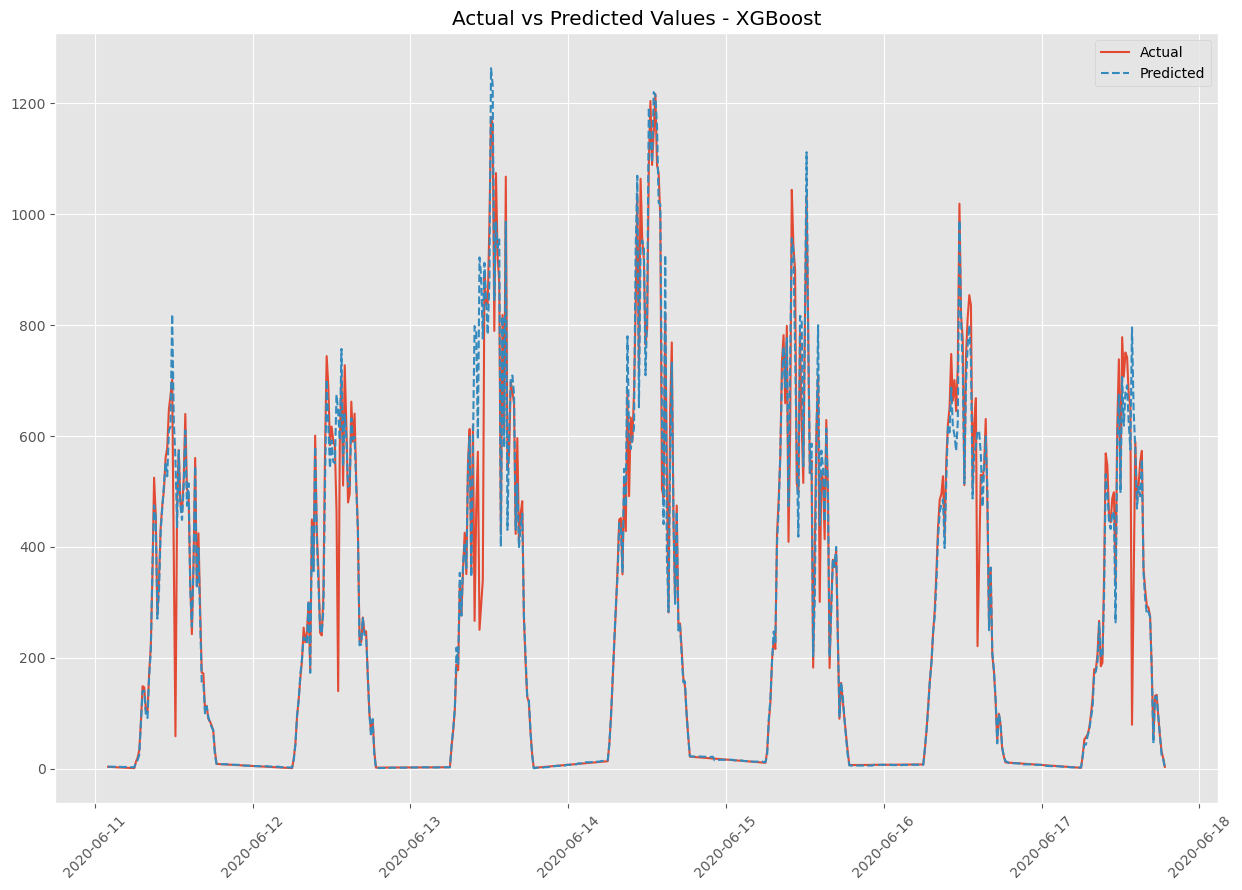

In [55]:
# Plot XGBoost predictions
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - XGBoost')
plt.legend()
plt.xticks(rotation=45)
plt.show()

<a id="XGboost-Tuning"></a>
##### 3.7.2.4.1 Making a k-fold cross-validation with hyperparameter tuning for the XGBoost

In [70]:
# Define the range of number of splits
num_splits_range = [3, 5, 7, 10]

# Dictionary to store cross-validation scores for each number of splits
cv_scores_xgb_test = {}
cv_scores_xgb_train = {}

for num_splits in num_splits_range:
    # Define cross-validation strategy with the current number of splits
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # Define the XGBoost Regression model
    xgb_model = xgb.XGBRegressor()
    
    # Perform hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1]
        
    }
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train.values.ravel())
    
    # Print best estimator and best score
    print(f"{num_splits}-fold Cross-Validation Best Estimator:")
    print(grid_search.best_estimator_)
    print(f"{num_splits}-fold Cross-Validation Best Score (RMSE):")
    print(-grid_search.best_score_)
    
    # Get the best model
    best_xgb_model = grid_search.best_estimator_
    
    # Evaluate the best model using cross-validation on the training set
    cv_scores_xgb_train[num_splits] = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Evaluate the best model using cross-validation on the testing set
    cv_scores_xgb_test[num_splits] = cross_val_score(best_xgb_model, X_test_scaled, y_test, cv=kf, scoring='neg_root_mean_squared_error')

# Print the cross-validation scores for each number of splits
for num_splits in num_splits_range:
    print(f"{num_splits}-fold Cross-Validation Scores (RMSE):")
    
    # Mean cross-validation score on the training set
    mean_cv_score_train = -np.mean(cv_scores_xgb_train[num_splits])
    print("Mean cross-validation RMSE score on training set:", mean_cv_score_train)
    
    # Mean cross-validation score on the testing set
    mean_cv_score_test = -np.mean(cv_scores_xgb_test[num_splits])
    print("Mean cross-validation RMSE score on testing set:", mean_cv_score_test)
    
    # Standard deviation in cross-validation scores on the testing set
    std_cv_score_test = np.std(cv_scores_xgb_test[num_splits])
    print("Standard deviation in cross-validation RMSE scores on testing set:", std_cv_score_test)

3-fold Cross-Validation Best Estimator:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
3-fold Cross-Validation Best Score (RMSE):
70.06540204254979
5-fold Cross-Validation Best Estimator:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=No

In [71]:
# Define the data
data = {
    "Cross-Validation": ["3-fold", "5-fold", "7-fold", "10-fold"],
    "Max Depth": [3, 3, 3, 3],
    "N Estimators": [100, 100, 100, 100],
    "Learning Rate": [0.05, 0.05, 0.05, 0.05],
    "Best RMSE Score": [70.07, 68.43, 67.61, 65.59],
    "Mean CV RMSE Score (Testing Set)": [63.51, 62.76, 57.26, 58.61],
    "Standard Deviation": [7.87, 13.48, 18.83, 22.99]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the title
title = "XGBoost Model Cross-Validation Results"

# Display the title and DataFrame
print(title)
df

XGBoost Model Cross-Validation Results


,Cross-Validation,Max Depth,N Estimators,Learning Rate,Best RMSE Score,Mean CV RMSE Score (Testing Set),Standard Deviation
0,3-fold,3,100,0.05,70.07,63.51,7.87
1,5-fold,3,100,0.05,68.43,62.76,13.48
2,7-fold,3,100,0.05,67.61,57.26,18.83
3,10-fold,3,100,0.05,65.59,58.61,22.99


In [86]:
#!pip install tensorflow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 48.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 40.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 22.2 MB/s eta 0:00:00
  Created wheel for gast: filename=gast-0.6.0-py3-none-any.whl size=21172 sha256=d3d9ac5d6ebddaa771b23d04d2518a4a41d9b716a30935a3cc6505b71586d226
  Stored in directory: /Users/aysebusra/Library/Caches/pip/wheels/c9/4e/2b/7ebd05dfcb268f1763adf30441a0336a89103060ac35591f06
Successfully built gast
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0


<a id="XGBoost"></a>
#### 3.7.2.5 Neural Network

In [91]:
# Initialize and build the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Predict on the test set
y_pred_nn = nn_model.predict(X_test_scaled)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


In [92]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mape = mean_absolute_percentage_error(y_test, y_pred_nn) * 100

print(f"Neural Network RMSE: {rmse}")
print(f"Neural Network MAPE: {mape}")

Neural Network RMSE: 89.13731971339006
Neural Network MAPE: 47.19627007233107


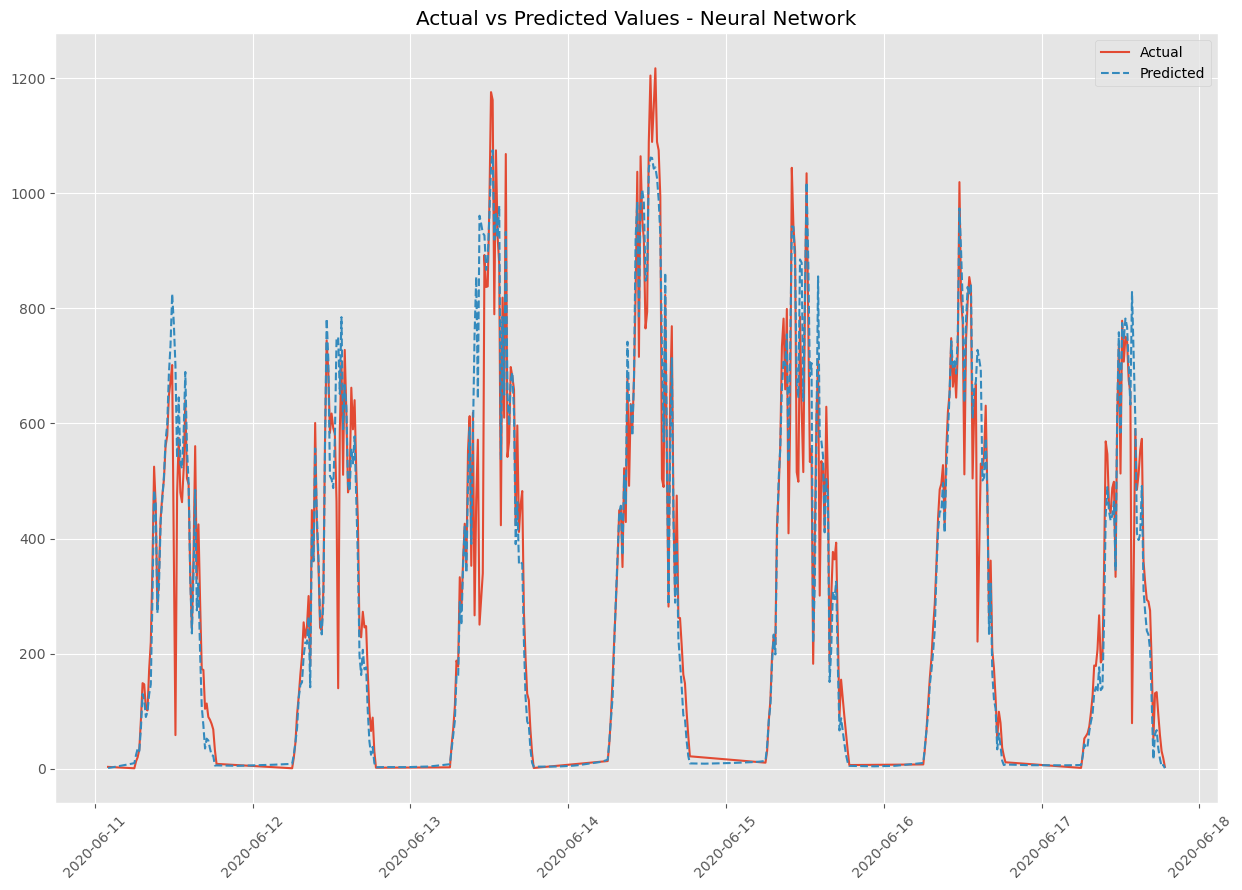

In [93]:
# Plot Neural Network predictions
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_nn, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - Neural Network')
plt.legend()
plt.xticks(rotation=45)
plt.show()

<a id="Model-Comparison"></a>
## 3.8 Model Comparison: Evaluating Performance Metrics

In [84]:
# Create a dictionary with the model results
data = {
    'Model': ['SARIMA', 'Random Forest Regression', 'XGBoost Regression'],
    'RMSE': [0.481, 0.923, 0.962],
    'MAPE': [8.032, 2.665, 2.008],
    'Mean Cross-Validation RMSE Score on Testing Set': ['-', '10-fold: 0.781', '10-fold: 0.926']
}

# Set the title
title = "Comparison of Models"

# Create a DataFrame
df = pd.DataFrame(data).reset_index(drop=True)

# Display the DataFrame
print(title)
df

Comparison of Models


,Model,RMSE,MAPE,Mean Cross-Validation RMSE Score on Testing Set
0,SARIMA,0.481,8.032,-
1,Random Forest Regression,0.923,2.665,10-fold: 0.781
2,XGBoost Regression,0.962,2.008,10-fold: 0.926
